# TUTORIAL: 
# Low order model of nonlinear thermocaoustic instabilities

In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from essentials.physical_models import Annular
import numpy as np
import mediapy as media
import os

## 1. Define the thermoacoustic low order model

#### Thermoacoustic model


#### Example thermoacoustic modes:
* Spinning modes: nu = 30., c2beta = 5.  
* Standing modes: nu = 1., c2beta = 25.  
* Mixed mode: nu = 20., c2beta = 18.  

In [6]:
case = Annular(nu=30., c2beta=52)

state, t_ = case.time_integrate(int(case.t_transient * 3 / case.dt))
case.update_history(state, t_)


## 2. Visualize acoustic modes

The state vector is formed of
$$
\psi = [\eta_a; \dot{\eta}_a; \eta_b; \dot{\eta}_b],
$$
where $\eta_a, \eta_b$ are the acoustic velocity modes and $\dot{\eta}_a, \dot{\eta}_b$ are the acoustic pressure modes.


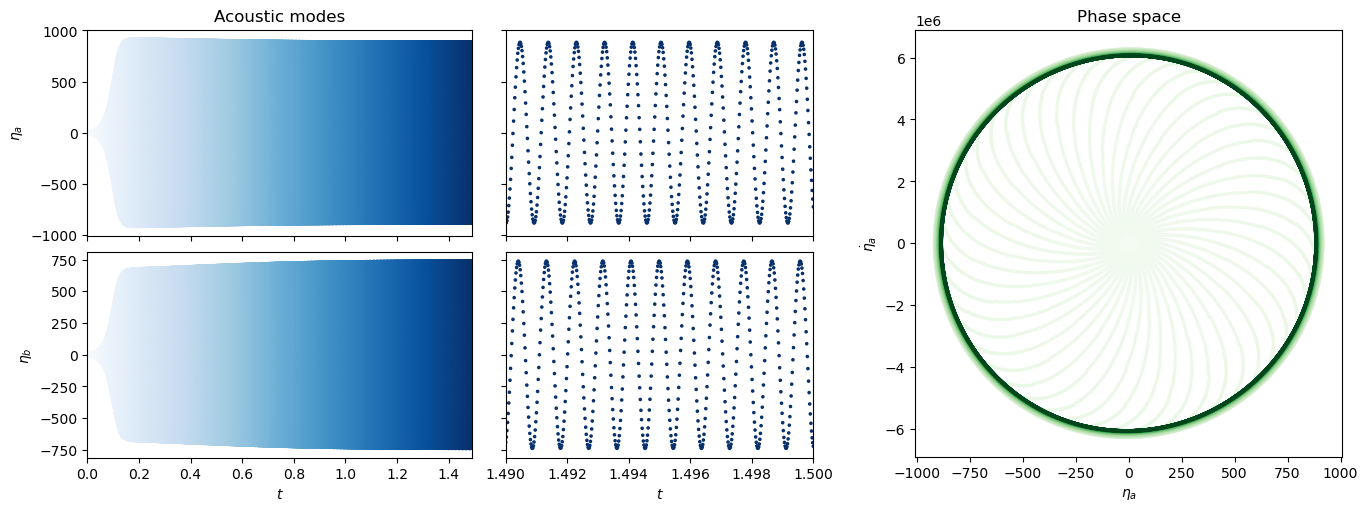

In [7]:
fig1 = plt.figure(figsize=(14, 5), layout="constrained")
sub_fig1 = fig1.subfigures(1, 2, width_ratios=[1.5, 1])
axs = sub_fig1[0].subplots(2, 2, sharex='col', sharey='row', width_ratios=[1, 0.8])
Nt_zoom = int(case.t_CR / case.dt)
xlims = [[case.hist_t[0], case.hist_t[-1]-case.t_CR], [case.hist_t[-1]-case.t_CR, case.hist_t[-1]]]
for axs_, xl, tl in zip([axs[:, 0], axs[:, 1]], xlims, ['Acoustic modes', '']):
    for ii, ax, lbl in zip([0, 2], axs_, ['$\eta_a$', '$\eta_b$']):
        ax.scatter(case.hist_t, case.hist[:, ii], c=case.hist_t, cmap='Blues', s=10, marker='.')
        if xl == xlims[0]:
            ax.set(ylabel=lbl)
    axs_[-1].set(xlabel='$t$', xlim=xl)
    axs_[0].set_title(tl)
ax = sub_fig1[1].subplots(1, 1)
ax.set_title('Phase space')
ax.scatter(case.hist[:, 0], case.hist[:, 1], c=case.hist_t, cmap='Greens', s=10, marker='.')
ax.set(xlabel='$\eta_a$', ylabel='$\dot{\eta}_a$')
ax.set_aspect(1. / ax.get_data_ratio())


## 3. Visualize acoustic pressure in the annular combustor

The acoustic pressure at an azimuthal angle $\theta$ is computed as 
$$
p(\theta, t) = \eta_a(t) \cos(n\theta) + \eta_b(t) \sin(n\theta).
$$
The angle $\theta$ is defined such that $\theta=0^\circ$ corresponds to the bottom centre line of the combustor.
<br><br>
*Note: the animation requires the "mediapy" module.*

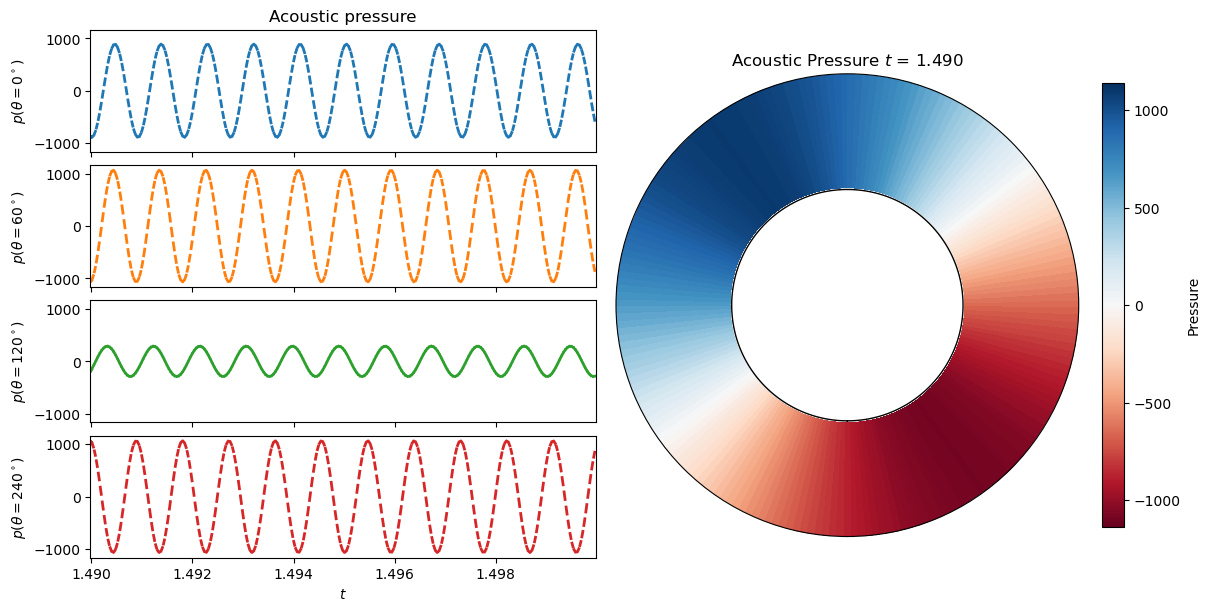

In [13]:
pressure_video_name = 'figs_TA_azimuthal/'
os.makedirs(pressure_video_name, exist_ok=True)
pressure_video_name += 'nu{}_c2beta{}.gif'.format(case.nu, case.c2beta)

if not os.path.isfile(pressure_video_name):
    y = case.get_observable_hist()
    lbl = case.obs_labels
    
    fig1 = plt.figure(figsize=(12, 6), layout="constrained")
    sub_fig1 = fig1.subfigures(1, 2, width_ratios=[1., 1])
    axs = sub_fig1[0].subplots(case.Nq, 1, sharex='col', sharey=True)
    for ax, ii, lbl in zip(axs, np.arange(case.Nq), case.obs_labels):
        ax.scatter(case.hist_t, y[:, ii], c='w')
        ax.set(ylabel=lbl)
    axs[-1].set(xlabel='$t$', xlim=[case.hist_t[0], case.hist_t[-1]])
    axs[0].set_title('Acoustic pressure');
    
    ax2 = sub_fig1[1].subplots(1, 1, subplot_kw={'projection': 'polar'})
    angles = np.linspace(0, 2 * np.pi, 200)  # Angles from 0 to 2π
    y_all = case.get_observable_hist(loc=angles)
    y_all = np.mean(y_all, axis=-1)
    
    radius = [0, 0.5, 1]
    theta, r = np.meshgrid(angles, radius)
    
    # Remove radial tick labels
    ax2.set(yticklabels=[], theta_zero_location='S', title='Acoustic Pressure',
            theta_direction=1, rgrids=[], thetagrids=[])
    
    # Add a white concentric circle
    circle_radius = 0.5
    ax2.plot(angles, [circle_radius] * len(angles), color='black', lw=1)
    
    idx_max = np.argmax(y_all[:, 0])
    polar_mesh = ax2.pcolormesh(theta, r, [y_all[idx_max].T] * len(radius), shading='auto', cmap='RdBu')
    
    start_i = int((case.hist_t[-1] - .01) // case.dt)
    dt_gif = 2
    t_gif = case.hist_t[start_i::dt_gif]
    y_gif = y_all[start_i::dt_gif]
    y = y[start_i:]
    t = case.hist_t[start_i:]
    axs[-1].set(xlim=[t_gif[0], t_gif[-1]])
    
    def update(frame):
        i0 = frame * dt_gif
        for ax, ii, lbl in zip(axs, np.arange(case.Nq), case.obs_labels):
            ax.plot(t[i0:i0+dt_gif], y[i0:i0+dt_gif, ii], c='C{}'.format(ii), lw=2)
            ax.set(ylabel=lbl)
        
        ax2.fill(angles, [circle_radius] * len(angles), color='white')
        polar_mesh.set_array([y_gif[frame+1].T] * len(radius))
        ax2.set_title('Acoustic Pressure $t$ = {:.3f}'.format(t_gif[frame+1]))  
    
    plt.colorbar(polar_mesh, label='Pressure', shrink=0.75)
    anim = FuncAnimation(fig1, update,  frames=len(t_gif)-1)
    anim.save(pressure_video_name, fps=15)
    
# Load and show the video
video = media.read_video(pressure_video_name)
media.show_video(video, width=900)